# Example 1d: Spin-Bath model, fitting of spectrum and correlation functions

### Introduction

The HEOM method solves the dynamics and steady state of a system and its environment, the latter of which is encoded in a set of auxiliary density matrices.

In this example we show the evolution of a single two-level system in contact with a single bosonic environment.

The properties of the system are encoded in Hamiltonian, and a coupling operator which describes how it is coupled to the environment.

The bosonic environment is implicitly assumed to obey a particular Hamiltonian (see paper), the parameters of which are encoded in the spectral density, and subsequently the free-bath correlation functions.

In the example below we show how model an Ohmic environment with exponential cut-off in two ways:

* First we fit the spectral density with a set of underdamped brownian oscillator functions.

* Second, we evaluate the correlation functions, and fit those with a certain choice of exponential functions.

In each case we will use the fit parameters to determine the correlation function expansion co-efficients needed to construct a description of the bath (i.e. a `BosonicBath` object) to supply to the `HEOMSolver` so that we can solve for the system dynamics.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import contextlib
import time

import numpy as np

from scipy.optimize import curve_fit

from qutip import *
from qutip.nonmarkov.heom import HEOMSolver, BosonicBath

# Import mpmath functions for evaluation of gamma and zeta functions in the expression for the correlation:

from mpmath import mp

mp.dps = 15
mp.pretty = True

In [3]:
def cot(x):
    """ Vectorized cotangent of x. """
    return 1. / np.tan(x)

In [4]:
def coth(x):
    """ Vectorized hyperbolic cotangent of x. """
    return 1. / np.tanh(x)

In [5]:
def plot_result_expectations(plots, axes=None):
    """ Plot the expectation values of operators as functions of time.
    
        Each plot in plots consists of (solver_result, measurement_operation, color, label).
    """
    if axes is None:
        fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
        fig_created = True
    else:
        fig = None
        fig_created = False

    # add kw arguments to each plot if missing
    plots = [p if len(p) == 5 else p + ({},) for p in plots]
    for result, m_op, color, label, kw in plots:
        exp = np.real(expect(result.states, m_op))
        kw.setdefault("linewidth", 2)
        axes.plot(result.times, exp, color, label=label, **kw)

    if fig_created:
        axes.legend(loc=0, fontsize=12)
        axes.set_xlabel("t", fontsize=28)

    return fig

In [6]:
@contextlib.contextmanager
def timer(label):
    """ Simple utility for timing functions:
    
        with timer("name"):
            ... code to time ...
    """
    start = time.time()
    yield
    end = time.time()
    print(f"{label}: {end - start}")

In [7]:
# Defining the system Hamiltonian
eps = .0    # Energy of the 2-level system.
Del = .2    # Tunnelling term
Hsys = 0.5 * eps * sigmaz() + 0.5 * Del * sigmax()

In [8]:
# Initial state of the system.
rho0 = basis(2,0) * basis(2,0).dag()  

### Analytical expressions for the Ohmic bath correlation function and spectral density

Before we begin fitting, let us examine the analytic expressions for the correlation and spectral density functions and write Python equivalents. 

The correlation function is given by (see, e.g., http://www1.itp.tu-berlin.de/brandes/public_html/publications/notes.pdf for a derivation, equation 7.59):

\begin{align}
C(t) =& \: 2 \alpha \omega_{c}^{1 - s} \beta^{- (s + 1)} \: \times \\
      & \: \Gamma(s + 1) \left[ \zeta \left(s + 1, \frac{1 + \beta \omega_c - i \omega_c t}{\beta \omega_c}\right) + \zeta \left(s + 1, \frac{1 + i \omega_c t}{\beta \omega_c}\right) \right]
\end{align}

where $\Gamma$ is the Gamma function and

\begin{equation}
\zeta(z, u) \equiv \sum_{n=0}^{\infty} \frac{1}{(n + u)^z}, \; u \neq 0, -1, -2, \ldots
\end{equation}

is the generalized Zeta function. The Ohmic case is given by $s = 1$.

The corresponding spectral density for the Ohmic case is:

\begin{equation}
J(\omega) = \omega \alpha e^{- \frac{\omega}{\omega_c}}
\end{equation}

In [9]:
# Zero temperature limit:
#
# \begin{equation}
# C(t) = 2 \alpha \omega_{c}^{s + 1} \Gamma(s + 1) (1 + i \omega_{c} t)^{-(s + 1)}
# \end{equation}
#
# where $\Gamma$ is the Gamma function and $s = 1$ gives the Ohmic case.

In [10]:
def ohmic_correlation(t, alpha, wc, beta, s=1):
    """ The Ohmic bath correlation function as a function of t (and the bath parameters). """
    # original code had (1/pi) instead of 2 as the prefactor; why?
    corr = 2 * alpha * wc**(1 - s) * beta**(-(s + 1)) * mp.gamma(s + 1)
    z1_u = (1 + beta * wc - 1.0j * wc * t) / (beta * wc)
    z2_u = (1 + 1.0j * wc * t) / (beta * wc)
    # Note: the arguments to zeta should be in as high precision as possible.
    # See http://mpmath.org/doc/current/basics.html#providing-correct-input
    return np.array([
        corr * (mp.zeta(s + 1, u1) + mp.zeta(s + 1, u2))
        for u1, u2 in zip(z1_u, z2_u)
    ], dtype=np.complex128)

# TODO: Remove old implementation at the end:
# corr = [complex((1/pi)*alpha * wc**(1-s) * beta**(-(s+1)) * (zeta(s+1,(1+beta*wc-1.0j*wc*t)/(beta*wc)) + 
#         zeta(s+1,(1+1.0j*wc*t)/(beta*wc)))) for t in tlist]

In [11]:
def ohmic_spectral_density(w, alpha, wc):
    """ The Ohmic bath spectral density as a function of w (and the bath parameters). """
    return w * alpha * e**(-w / wc)

In [12]:
def ohmic_power_spectrum(w, alpha, wc, beta):
    """ The Ohmic bath power spectrum as a function of w (and the bath parameters). """
    return w * alpha * e**(-abs(w) / wc) * ((1 / (e**(w * beta) - 1)) + 1)

Finally, let's set the bath parameters we will work with and write down some measurement operators:

In [13]:
# Bath parameters:

Q = sigmaz()  # coupling operator

alpha = 3.25
T = 0.5
wc = 1
beta = 1 / T 
s = 1

In [14]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p = basis(2,0) * basis(2,0).dag()
P22p = basis(2,1) * basis(2,1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p = basis(2,0) * basis(2,1).dag()

### Building the HEOM bath by fitting the spectral density

We begin by fitting the spectral density, using a series of $k$ underdamped harmonic oscillators case with the Meier-Tannor form:

\begin{equation}
J_{\mathrm approx}(\omega; a, b, c) = \sum_{i=0}^{k-1} \frac{2 a_i b_i w}{((w + c_i)^2 + b_i^2) ((w - c_i)^2 + b_i^2)}
\end{equation}

where $a, b$ and $c$ are the fit parameters and each is a vector of length $k$.

<span style="color:red">*TODO: What is the Meier-Tannor form? Reference?*</span>

In [15]:
# Helper functions for packing the paramters a, b and c into a single numpy
# array as required by SciPy's curve_fit:

def pack(a, b, c):
    """ Pack parameter lists for fitting. """
    return np.concatenate((a, b, c))
    

def unpack(params):
    """ Unpack parameter lists for fitting. """
    N = len(params) // 3
    a = params[:N]
    b = params[N:2 * N]
    c = params[2 * N:]
    return a, b, c

In [16]:
# The approximate spectral density and a helper for fitting the approximate spectral density
# to values calculated from the analytical formula:

def spectral_density_approx(w, a, b, c):
    """ Calculate the fitted value of the function for the given parameters. """
    tot = 0
    for i in range(len(a)):
        tot += 2 * a[i] * b[i] * w / (((w + c[i])**2 + b[i]**2) * ((w - c[i])**2 + b[i]**2))
    return tot


def fit_spectral_density(J, w, alpha, wc, N):
    """ Fit the spectral density with N underdamped oscillators. """
    sigma = [0.0001] * len(w)

    J_max = abs(max(J, key=abs))

    guesses = pack([J_max] * N, [wc] * N, [wc] * N)
    lower_bounds = pack([-100 * J_max] * N, [0.1 * wc] * N, [0.1 * wc] * N)
    upper_bounds = pack([100 * J_max] * N, [100 * wc] * N, [100 * wc] * N)

    params, _ = curve_fit(
        lambda x, *params: spectral_density_approx(w, *unpack(params)),
        w, J,
        p0=guesses,
        bounds=(lower_bounds, upper_bounds),
        sigma=sigma,
        maxfev=1000000000,
    )

    return unpack(params)

With the spectral density approximation $J_{\mathrm approx}(w; a, b, c)$ implemented above, we can now perform the fit and examine the results.

In [17]:
w = np.linspace(0, 25, 20000)
J = ohmic_spectral_density(w, alpha=alpha, wc=wc)

params_k = [
    fit_spectral_density(J, w, alpha=alpha, wc=wc, N=i+1)
    for i in range(4)
]

Let's plot the fit for each $k$ and examine how it improves with an increasing number of terms:

Parameters [k=0]: lam=[6.14746382]; gamma=[1.77939431]; w0=[0.1]


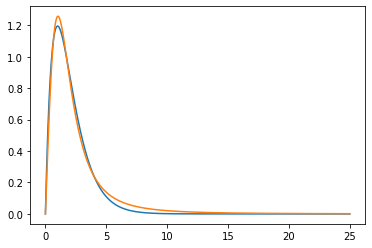

Parameters [k=1]: lam=[3.26249432 2.2118916 ]; gamma=[1.43449511 1.24955752]; w0=[1.80554867 0.1       ]


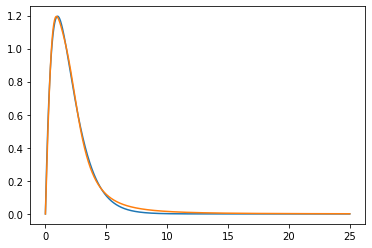

Parameters [k=2]: lam=[2.33963005 1.64990522 1.12724261]; gamma=[1.09363643 1.18458586 1.00870064]; w0=[1.37014918 2.69764359 0.13300955]


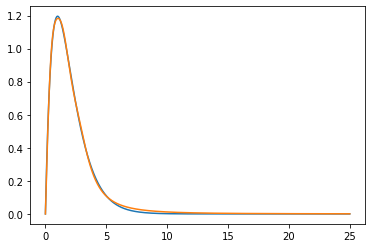

Parameters [k=3]: lam=[ 7.91592691  0.60083715 -4.40789264  0.01058515]; gamma=[2.29618998 1.00246807 4.29908162 0.30736326]; w0=[0.1        0.1        3.98168654 0.1       ]


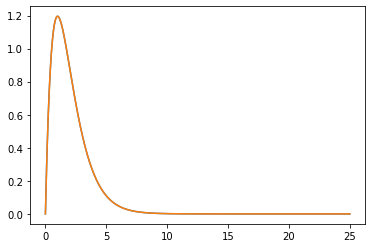

In [18]:
for k, params in enumerate(params_k):
    lam, gamma, w0 = params
    y = spectral_density_approx(w, lam, gamma, w0)
    print(f"Parameters [k={k}]: lam={lam}; gamma={gamma}; w0={w0}")
    plt.plot(w, J, w, y)
    plt.show()

The fit with four terms looks good. Let's take a closer look at it by plotting the contribution of each term of the fit:

In [19]:
# The parameters for the fit with four terms:

lam, gamma, w0 = params_k[-1]
print(f"Parameters [k={len(params_k) - 1}]: lam={lam}; gamma={gamma}; w0={w0}")

Parameters [k=3]: lam=[ 7.91592691  0.60083715 -4.40789264  0.01058515]; gamma=[2.29618998 1.00246807 4.29908162 0.30736326]; w0=[0.1        0.1        3.98168654 0.1       ]


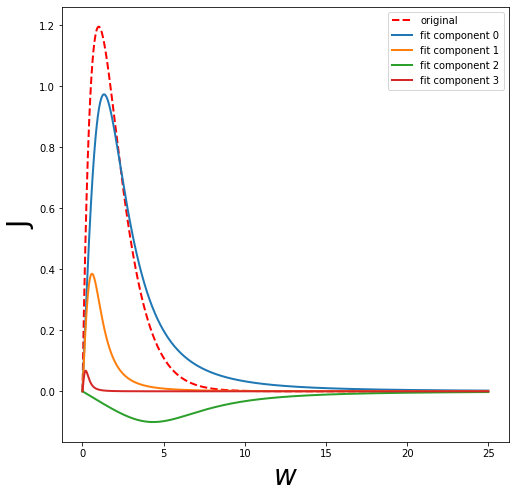

In [20]:
# Plot the components of the fit separately:

def spectral_density_ith_component(w, i, lam, gamma, w0):
    """ Return the i'th term of the approximation for the spectral density. """
    return 2 * lam[i] * gamma[i] * w / (((w + w0[i])**2 + gamma[i]**2) * ((w - w0[i])**2 + gamma[i]**2))
    

def plot_spectral_density_fit_components(J, w, lam, gamma, w0, save=True):
    """ Plot the individual components of a fit to the spectral density. """
    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
    axes.plot(w, J, 'r--', linewidth=2, label="original")
    for i in range(len(lam)):
        axes.plot(
            w, spectral_density_ith_component(w, i, lam, gamma, w0),
            linewidth=2,
            label=f"fit component {i}",
    )

    axes.set_xlabel(r'$w$', fontsize=28)
    axes.set_ylabel(r'J', fontsize=28)
    axes.legend()

    if save:
        fig.savefig('noisepower.eps')


plot_spectral_density_fit_components(J, w, lam, gamma, w0, save=False)

And let's also compare the power spectrum of the fit and the analytical spectral density:

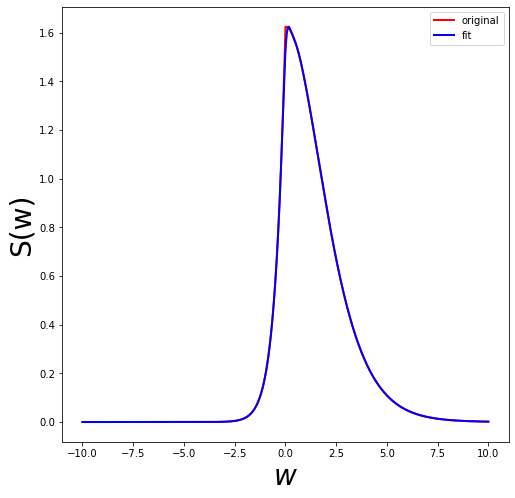

In [21]:
def plot_power_spectrum(alpha, wc, beta, lam, gamma, w0, save=True):
    """ Plot the power spectrum of a fit against the actual power spectrum. """
    w = np.linspace(-10, 10, 50000)

    s_orig = ohmic_power_spectrum(w, alpha=alpha, wc=wc, beta=beta)
    s_fit = spectral_density_approx(w, lam, gamma, w0) * ((1 / (e**(w * beta) - 1)) + 1)
    
    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
    axes.plot(w, s_orig, 'r', linewidth=2, label="original")
    axes.plot(w, s_fit, 'b', linewidth=2, label="fit")

    axes.set_xlabel(r'$w$', fontsize=28)
    axes.set_ylabel(r'S(w)', fontsize=28)
    axes.legend()

    if save:
        fig.savefig('powerspectrum.eps')


plot_power_spectrum(alpha, wc, beta, lam, gamma, w0, save=False)

Now that we have a good fit to the spectral density, we can calculate the Matsubara expansion terms for the `BosonicBath` from them. At the same time we will calculate the Matsubara terminator for this expansion.

In [22]:
def matsubara_coefficients_from_spectral_fit(lam, gamma, w0, beta, Q, Nk):
    """ Calculate the Matsubara co-efficients for a fit to the spectral density. """

    terminator = 0. * spre(Q)  # initial 0 value with the correct dimensions
    terminator_max_k = 1000  # the number of matsubara expansion terms to include in the terminator
    
    ckAR = []
    vkAR = []
    ckAI = []
    vkAI = []

    for lamt, Gamma, Om in zip(lam, gamma, w0):
        ckAR.extend([
            (lamt / (4 * Om)) * coth(beta * (Om + 1.0j * Gamma) / 2),
            (lamt / (4 * Om)) * coth(beta * (Om - 1.0j * Gamma) / 2),
        ])
        for k in range(1, Nk + 1):
            ek = 2 * np.pi * k / beta
            ckAR.append(
                (-2 * lamt * 2 * Gamma / beta) * ek /
                (((Om + 1.0j * Gamma)**2 + ek**2) * ((Om - 1.0j * Gamma)**2 + ek**2))
            )

        terminator_factor = 0
        for k in range(Nk + 1, terminator_max_k):
            ek = 2 * pi * k / beta
            ck = (
                (-2 * lamt * 2 * Gamma / beta) * ek /
                (((Om + 1.0j * Gamma)**2 + ek**2) * ((Om - 1.0j * Gamma)**2 + ek**2))
            )
            terminator_factor += ck / ek
        terminator += terminator_factor * (
            2 * spre(Q) * spost(Q.dag()) - spre(Q.dag() * Q) - spost(Q.dag() * Q)
        )

        vkAR.extend([
            -1.0j * Om + Gamma,
            1.0j * Om + Gamma,
        ])
        vkAR.extend([
            2 * np.pi * k * T + 0.j
            for k in range(1, Nk + 1)
        ])

        ckAI.extend([
            -0.25 * lamt * 1.0j / Om,
            0.25 * lamt * 1.0j / Om,
        ])
        vkAI.extend([
            -(-1.0j * Om - Gamma),
            -(1.0j * Om - Gamma),
        ])
        
    return ckAR, vkAR, ckAI, vkAI, terminator

In [23]:
options = Options(nsteps=15000, store_states=True, rtol=1e-12, atol=1e-12, method="bdf")
# This problem is a little stiff, so we use  the BDF method to solve the ODE ^^^

ckAR, vkAR, ckAI, vkAI, terminator = matsubara_coefficients_from_spectral_fit(lam, gamma, w0, beta=beta, Q=Q, Nk=1)
Ltot = liouvillian(Hsys) + terminator
tlist = np.linspace(0, 30 * pi / Del, 600)

with timer("RHS construction time"):
    bath = BosonicBath(Q, ckAR, vkAR, ckAI, vkAI)
    HEOM_spectral_fit = HEOMSolver(Ltot, bath, max_depth=5, options=options)
    
with timer("ODE solver time"):
    results_spectral_fit = HEOM_spectral_fit.run(rho0, tlist)

RHS construction time: 0.7033712863922119
ODE solver time: 10.735771417617798


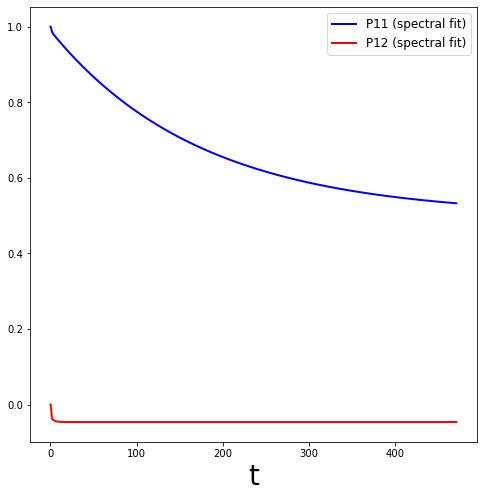

In [24]:
plot_result_expectations([
    (results_spectral_fit, P11p, 'b', "P11 (spectral fit)"),
    (results_spectral_fit, P12p, 'r', "P12 (spectral fit)"),
]);

### Building the HEOM bath by fitting the correlation function

Having successfully fitted the spectral density and used the result to calculate the Matsubara expansion and terminator for the HEOM bosonic bath, we now proceed to the second case of fitting the correlation function itself instead.

XXX

begin by fitting the spectral density, using a series of $k$ underdamped harmonic oscillators case with the Meier-Tannor form:

\begin{equation}
J_{\mathrm approx}(\omega; a, b, c) = \sum_{i=0}^{k-1} \frac{2 a_i b_i w}{((w + c_i)^2 + b_i^2) ((w - c_i)^2 + b_i^2)}
\end{equation}

where $a, b$ and $c$ are the fit parameters and each is a vector of length $k$.

In [25]:
# The approximate correlation functions and a helper for fitting the approximate correlation
# function to values calculated from the analytical formula:

def correlation_approx_real(t, a, b, c):
    """ Calculate the fitted value of the function for the given parameters. """
    tot = 0
    for i in range(len(a)):
        tot += a[i] * np.exp(b[i] * t) * np.cos(c[i] * t)
    return tot      


def correlation_approx_imag(t, a, b, c):
    """ Calculate the fitted value of the function for the given parameters. """
    tot = 0
    for i in range(len(a)):
        tot += a[i] * np.exp(b[i] * t) * np.sin(c[i] * t)    
    return tot


def fit_correlation_real(C, t, wc, N):
    """ Fit the spectral density with N underdamped oscillators. """
    sigma = [0.1] * len(t)

    C_max = abs(max(C, key=abs))

    guesses = pack([C_max] * N, [-wc] * N, [wc] * N)
    lower_bounds = pack([-20 * C_max] * N, [-np.inf] * N, [0.] * N)
    upper_bounds = pack([20 * C_max] * N, [0.1] * N, [np.inf] * N)

    params, _ = curve_fit(
        lambda x, *params: correlation_approx_real(t, *unpack(params)),
        t, C,
        p0=guesses,
        bounds=(lower_bounds, upper_bounds),
        sigma=sigma,
        maxfev=1000000000,
    )

    return unpack(params)


def fit_correlation_imag(C, t, wc, N):
    """ Fit the spectral density with N underdamped oscillators. """
    sigma = [0.0001] * len(t)

    C_max = abs(max(C, key=abs))

    guesses = pack([-C_max] * N, [-2] * N, [1] * N)
    lower_bounds = pack([-5 * C_max] * N, [-100] * N, [0.] * N)
    upper_bounds = pack([5 * C_max] * N, [0.01] * N, [100] * N)

    params, _ = curve_fit(
        lambda x, *params: correlation_approx_imag(t, *unpack(params)),
        t, C,
        p0=guesses,
        bounds=(lower_bounds, upper_bounds),
        sigma=sigma,
        maxfev=1000000000,
    )

    return unpack(params)    

In [26]:
# capture both long and short timescales:
t = np.concatenate([np.linspace(0, 1, 2000), np.linspace(1, 25, 1000)])
C = ohmic_correlation(t, alpha=alpha, wc=wc, beta=beta)

params_k_real = [
    fit_correlation_real(np.real(C), t, wc=wc, N=i+1)
    for i in range(4)
]

params_k_imag = [
    fit_correlation_imag(np.imag(C), t, wc=wc, N=i+1)
    for i in range(4)
]

Parameters [k=0]: lam=[10.4996814]; gamma=[-0.98092778]; w0=[0.82622616]


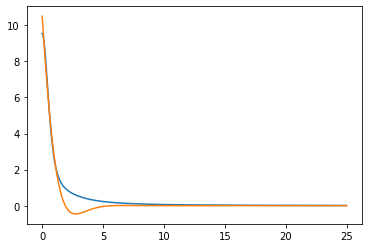

Parameters [k=1]: lam=[4.14626535 5.95942316]; gamma=[-0.73721013 -0.58256683]; w0=[1.94418451 0.310477  ]


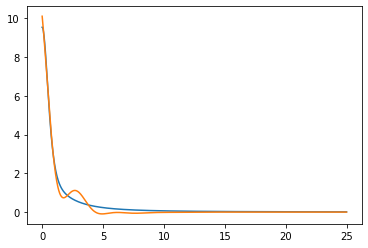

Parameters [k=2]: lam=[3.40433438 4.33757345 2.23119339]; gamma=[-0.55135002 -0.43750123 -0.63565237]; w0=[1.19850988 0.22109599 2.5883685 ]


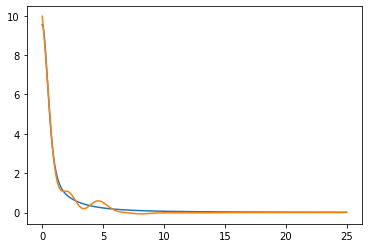

Parameters [k=3]: lam=[  2.32850513   0.2445664   17.77126004 -10.7943798 ]; gamma=[-0.61462434 -0.14090983 -2.74941557 -4.60094715]; w0=[7.40617620e-07 1.04178977e-20 5.36835648e-01 2.66493283e+00]


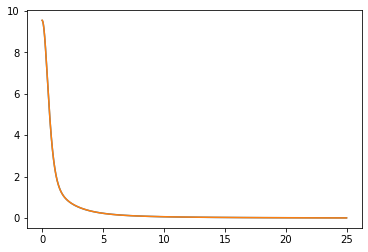

In [27]:
for k, params in enumerate(params_k_real):
    lam, gamma, w0 = params
    y = correlation_approx_real(t, lam, gamma, w0)
    print(f"Parameters [k={k}]: lam={lam}; gamma={gamma}; w0={w0}")
    plt.plot(t, np.real(C), t, y)
    plt.show()

Parameters [k=0]: lam=[-17.05301139]; gamma=[-1.44175796]; w0=[1.01155336]


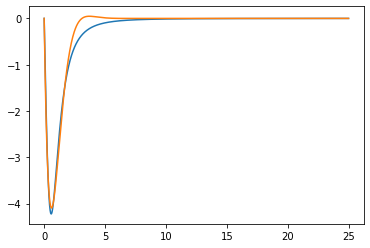

Parameters [k=1]: lam=[ -2.99939986 -10.71561109]; gamma=[-0.95325788 -1.0270222 ]; w0=[2.51537897 0.74129256]


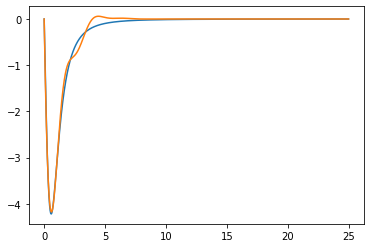

Parameters [k=2]: lam=[-1.36226133 -7.47874644 -3.38985229]; gamma=[-0.76588517 -0.83910998 -0.800724  ]; w0=[3.24770214 0.59387543 1.7636631 ]


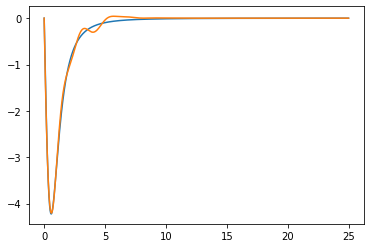

Parameters [k=3]: lam=[-3.14165233 -5.7009435  -1.70262159 -0.78793558]; gamma=[-0.68460063 -0.73118556 -0.67299582 -0.66963153]; w0=[1.42727943 0.50716175 2.44120171 3.76168532]


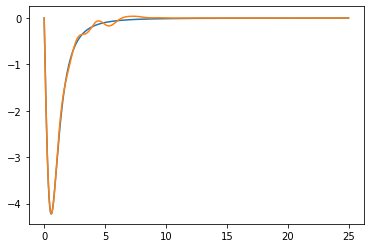

In [28]:
for k, params in enumerate(params_k_imag):
    lam, gamma, w0 = params
    y = correlation_approx_imag(t, lam, gamma, w0)
    print(f"Parameters [k={k}]: lam={lam}; gamma={gamma}; w0={w0}")
    plt.plot(t, np.imag(C), t, y)
    plt.show()

Now we construct the `BosonicBath` co-efficients and frequencies from the fit to the correlation function:

In [29]:
def matsubara_coefficients_from_corr_fit_real(lam, gamma, w0):
    """ Return the matsubara coefficients for the imaginary part of the correlation function """
    ckAR = [0.5 * x + 0j for x in lam]  # the 0.5 is from the cosine
    ckAR.extend(np.conjugate(ckAR))     # extend the list with the complex conjugates
    
    vkAR = [-x - 1.0j * y for x, y in zip(gamma, w0)]
    vkAR.extend([-x + 1.0j * y for x, y in zip(gamma, w0)])
    
    return ckAR, vkAR

def matsubara_coefficients_from_corr_fit_imag(lam, gamma, w0):
    """ Return the matsubara coefficients for the imaginary part of the correlation function. """
    ckAI = [-0.5j * x for x in lam]  # the 0.5 is from the sine
    ckAI.extend(np.conjugate(ckAI))  # extend the list with the complex conjugates
    
    vkAI = [-x - 1.0j * y for x, y in zip(gamma, w0)]
    vkAI.extend([-x + 1.0j * y for x, y in zip(gamma, w0)])
    
    return ckAI, vkAI

In [30]:
ckAR, vkAR = matsubara_coefficients_from_corr_fit_real(*params_k_real[-1])
ckAI, vkAI = matsubara_coefficients_from_corr_fit_imag(*params_k_imag[-1])

In [31]:
def correlation_approx_matsubara(t, ck, vk):
    """ Calculate the approximate real or imaginary part of the correlation function
        from the matsubara expansion co-efficients.
    """
    ck = np.array(ck)
    vk = np.array(vk)
    y = []
    for i in t:
        y.append(np.sum(ck * np.exp(-vk * i)))
    return y

In [32]:
def corr_spectrum_approx(w, ckAR, vkAR, ckAI, vkAI):
    """ Calculates the approximate Matsubara correlation spectrum from ck and vk. """
    J = np.zeros(len(w), dtype=np.complex128)
    for ck, vk in zip(ckAR, vkAR):
        J += ck * np.real(vk) / ((w - np.imag(vk))**2 + (np.real(vk)**2))
    for ck, vk in zip(ckAI, vkAI):
        J += 1.0j * ck * np.real(vk) / ((w - np.imag(vk))**2 + (np.real(vk)**2))
    return np.real(J)

In [33]:
def set_paper_figure_rcparams():
    matplotlib.rcParams['figure.figsize'] = (7, 5)
    matplotlib.rcParams['axes.titlesize'] = 25
    matplotlib.rcParams['axes.labelsize'] = 30
    matplotlib.rcParams['xtick.labelsize'] = 28
    matplotlib.rcParams['ytick.labelsize'] = 28
    matplotlib.rcParams['legend.fontsize'] = 20
    matplotlib.rcParams['axes.grid'] = False
    matplotlib.rcParams['savefig.bbox'] = 'tight'
    matplotlib.rcParams['lines.markersize'] = 5
    matplotlib.rcParams['font.family'] = 'STIXgeneral' 
    matplotlib.rcParams['mathtext.fontset'] =  'stix'
    matplotlib.rcParams["font.serif"] = "STIX"
    matplotlib.rcParams['text.usetex'] = False
    
set_paper_figure_rcparams()

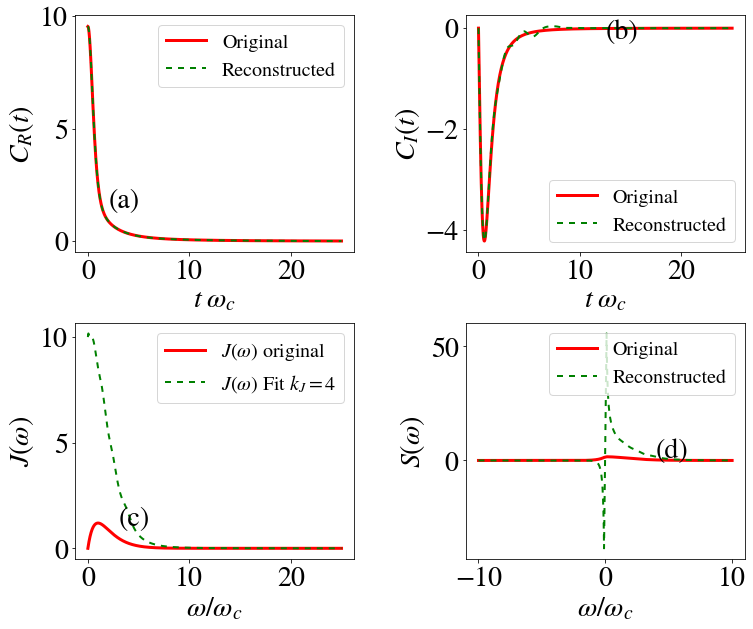

In [34]:
def plot_matsubara_correlation_fit_vs_actual(t, C, ckAR, vkAR, ckAI, vkAI):
    fig = plt.figure(figsize=(12, 10))
    grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)

    # C_R(t)
    
    yR = correlation_approx_matsubara(t, ckAR, vkAR)

    axes1 = fig.add_subplot(grid[0, 0])

    axes1.plot(t, np.real(C), "r", linewidth=3, label="Original")
    axes1.plot(t, np.real(yR), "g", dashes=[3, 3], linewidth=2, label="Reconstructed")

    axes1.legend(loc=0)
    axes1.set_ylabel(r'$C_R(t)$', fontsize=28)
    axes1.set_xlabel(r'$t\;\omega_c$', fontsize=28)
    axes1.locator_params(axis='y', nbins=4)
    axes1.locator_params(axis='x', nbins=4)
    axes1.text(2., 1.5, "(a)", fontsize=28)

    # C_I(t)

    yI = correlation_approx_matsubara(t, ckAI, vkAI)
    
    axes2 = fig.add_subplot(grid[0, 1])

    axes2.plot(t, np.imag(C), "r", linewidth=3, label="Original")
    axes2.plot(t, np.real(yI), "g", dashes=[3, 3], linewidth=2, label="Reconstructed")

    axes2.legend(loc=0)
    axes2.set_ylabel(r'$C_I(t)$', fontsize=28)
    axes2.set_xlabel(r'$t\;\omega_c$', fontsize=28)
    axes2.locator_params(axis='y', nbins=4)
    axes2.locator_params(axis='x', nbins=4)
    axes2.text(12.5, -0.2, "(b)", fontsize=28)
    
    # J(w)    

    w = np.linspace(0, 25, 20000)

    J_orig = ohmic_spectral_density(w, alpha=alpha, wc=wc)
    J_fit = corr_spectrum_approx(w, ckAR, vkAR, ckAI, vkAI)

    axes3 = fig.add_subplot(grid[1, 0])

    axes3.plot(w, J_orig, "r", linewidth=3, label="$J(\omega)$ original")
    axes3.plot(w, J_fit, "g", dashes=[3, 3], linewidth=2, label="$J(\omega)$ Fit $k_J = 4$")
    
    axes3.legend(loc=0)
    axes3.set_ylabel(r'$J(\omega)$', fontsize=28)
    axes3.set_xlabel(r'$\omega/\omega_c$', fontsize=28)
    axes3.locator_params(axis='y', nbins=4)
    axes3.locator_params(axis='x', nbins=4)
    axes3.text(3, 1.1, "(c)", fontsize=28)

    # S(w)

    # avoid the pole in the fit around zero:
    w = np.concatenate([np.linspace(-10, -0.1, 5000), np.linspace(0.1, 10, 5000)])
    
    s_orig = ohmic_power_spectrum(w, alpha=alpha, wc=wc, beta=beta)
    s_fit = corr_spectrum_approx(w, ckAR, vkAR, ckAI, vkAI) * ((1 / (e**(w * beta) - 1)) + 1)

    axes4 = fig.add_subplot(grid[1, 1])
    axes4.plot(w, s_orig,"r",linewidth=3,label="Original")
    axes4.plot(w, s_fit, "g", dashes=[3, 3], linewidth=2,label="Reconstructed")

    axes4.legend()
    axes4.set_ylabel(r'$S(\omega)$', fontsize=28)
    axes4.set_xlabel(r'$\omega/\omega_c$', fontsize=28)
    axes4.locator_params(axis='y', nbins=4)
    axes4.locator_params(axis='x', nbins=4)
    axes4.text(4., 1.2, "(d)", fontsize=28)

    if save:
        fig.savefig("figures/figFiJspec.pdf")


plot_matsubara_correlation_fit_vs_actual(t, C, ckAR, vkAR, ckAI, vkAI)

In [35]:
### TODO: THE J(w) and S(w) plots above are incorrect, but I don't know what is wrong. :|

In [36]:
options = Options(nsteps=15000, store_states=True, rtol=1e-12, atol=1e-12, method="bdf")
# This problem is a little stiff, so we use  the BDF method to solve the ODE ^^^

tlist = np.linspace(0, 30 * pi / Del, 600)

with timer("RHS construction time"):
    bath = BosonicBath(Q, ckAR, vkAR, ckAI, vkAI)
    HEOM_corr_fit = HEOMSolver(Hsys, bath, max_depth=5, options=options)
    
with timer("ODE solver time"):
    results_corr_fit = HEOM_corr_fit.run(rho0, tlist)

RHS construction time: 3.1501595973968506
ODE solver time: 112.63514113426208


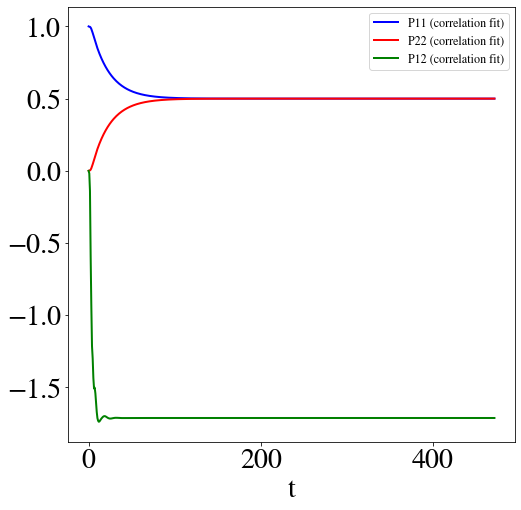

In [37]:
plot_result_expectations([
    (results_corr_fit, P11p, 'b', "P11 (correlation fit)"),
    (results_corr_fit, P22p, 'r', "P22 (correlation fit)"),
    (results_corr_fit, P12p, 'g', "P12 (correlation fit)"),
]);

In [38]:
### DECIDE WHAT TO DO WITH THE PLOTS, ETC AFTER HERE ###

In [39]:
XXX

NameError: name 'XXX' is not defined

In [ ]:
wlist2 = np.linspace(-7,7 , 50000)

s1 =  [w * alpha * e**(-abs(w)/wc) *  ((1/(e**(w/T)-1))+1) for w in wlist2]
s2 =  spectrum_approx(wlist2,ckAR,vkAR)
s2.extend(spectrum_approx(wlist2,[1.0j*ckk for ckk in ckAI],vkAI))

print(len(s2))
s2sum = [0. for w in wlist2]
for s22 in s2:
    for kk,ww in enumerate(wlist2):
        s2sum[kk] += s22[kk]

fig = plt.figure(figsize=(12,10))
grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)

axes1 = fig.add_subplot(grid[0,0])
axes1.set_yticks([0.,1.])
axes1.set_yticklabels([0,1]) 

y = checker(tlist2, popt1[2], 3)
axes1.plot(tlist2, corrRana,'r',linewidth=3,label="Original")
axes1.plot(tlist2, y,'g',dashes=[3,3],linewidth=3,label="Fit $k_R = 3$")
axes1.legend(loc=0)

axes1.set_ylabel(r'$C_R(t)$',fontsize=28)

axes1.set_xlabel(r'$t\;\omega_c$',fontsize=28)
axes1.locator_params(axis='y', nbins=3)
axes1.locator_params(axis='x', nbins=3)
axes1.text(2.5,0.5,"(a)",fontsize=28)

axes2 = fig.add_subplot(grid[0,1])
y = checker2(tlist2, popt2[2], 3)
axes2.plot(tlist2, corrIana,'r',linewidth=3,label="Original")
axes2.plot(tlist2, y,'g',dashes=[3,3],linewidth=3,label="Fit $k_I = 3$")
axes2.legend(loc=0)
axes2.set_yticks([0.,-0.4])
axes2.set_yticklabels([0,-0.4]) 

axes2.set_ylabel(r'$C_I(t)$',fontsize=28)

axes2.set_xlabel(r'$t\;\omega_c$',fontsize=28)
axes2.locator_params(axis='y', nbins=3)
axes2.locator_params(axis='x', nbins=3)
axes2.text(12.5,-0.1,"(b)",fontsize=28)


axes3 = fig.add_subplot(grid[1,0:])
axes3.plot(wlist2, s1,  'r',linewidth=3,label="$S(\omega)$ original")
axes3.plot(wlist2, real(s2sum),  'g',dashes=[3,3],linewidth=3, label="$S(\omega)$ reconstruction")

axes3.set_yticks([0.,1.])
axes3.set_yticklabels([0,1]) 

axes3.set_xlim(-5,5)

axes3.set_ylabel(r'$S(\omega)$',fontsize=28)

axes3.set_xlabel(r'$\omega/\omega_c$',fontsize=28)
axes3.locator_params(axis='y', nbins=3)
axes3.locator_params(axis='x', nbins=3)
axes3.legend(loc=1)
axes3.text(-4,1.5,"(c)",fontsize=28)

#fig.savefig("figures/figFitCspec.pdf")

In [ ]:
NC = 5

#Q2 = [Q for kk in range(NR+NI)]
#print(Q2)
options = Options(nsteps=1500, store_states=True, rtol=1e-12, atol=1e-12, method="bdf") 
import time

start = time.time()

#HEOMFit = BosonicHEOMSolver(Hsys, Q2, ckAR2, ckAI2, vkAR2, vkAI2, NC, options=options)
HEOMFitC = BosonicHEOMSolver(Hsys, Q2, ckAR, ckAI, vkAR, vkAI, NC, options=options)
print("hello")
end = time.time()
print(end - start)

In [ ]:
tlist4 = np.linspace(0, 30*pi/Del, 600)

resultFit = HEOMFitC.run(rho0, tlist4)

In [ ]:
# Calculate expectation values in the bases
P11expC11k33L = expect(resultFit.states, P11p)
P22expC11k33L = expect(resultFit.states, P22p)
P12expC11k33L = expect(resultFit.states, P12p)

In [ ]:
#Nc = 5

tlist4 = np.linspace(0, 4*pi/Del, 600)
# Plot the results
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,15))
axes[0].set_yticks([0.6,0.8,1])
axes[0].set_yticklabels([0.6,0.8,1]) 
axes[0].plot(tlist4, np.real(P11expC11k33L), 'y', linewidth=2, label="Correlation Function Fit $k_R=k_I=3$")

axes[0].plot(tlist4, np.real(P11exp11K3NK1TL), 'b-.', linewidth=2, label="Spectral Density Fit $k_J=3$, $N_k=1$ & Terminator")
axes[0].plot(tlist4, np.real(P11exp11K3NK2TL), 'r--', linewidth=2, label="Spectral Density Fit $k_J=3$, $N_k=2$ & Terminator")
axes[0].plot(tlist4, np.real(P11exp11K4NK1TL), 'g--', linewidth=2, label="Spectral Density Fit $k_J=4$, $N_k=1$ & Terminator")
axes[0].set_ylabel(r'$\rho_{11}$',fontsize=30)

axes[0].set_xlabel(r'$t\;\omega_c$',fontsize=30)
axes[0].locator_params(axis='y', nbins=3)
axes[0].locator_params(axis='x', nbins=3)
axes[0].legend(loc=0, fontsize=25)

#axes[1].set_yticks([0,0.01])
#axes[1].set_yticklabels([0,0.01]) 
#axes[0].plot(tlist4, np.real(P11exp11K3NK1TL)-np.real(P11expC11k33L), 'b-.', linewidth=2, label="Correlation Function Fit $k_R=k_I=3$")

axes[1].plot(tlist4, np.real(P11exp11K3NK1TL)-np.real(P11expC11k33L), 'b-.', linewidth=2, label="Spectral Density Fit $k_J=3$, $K=1$ & Terminator")

axes[1].plot(tlist4, np.real(P11exp11K3NK2TL)-np.real(P11expC11k33L), 'r--', linewidth=2, label="Spectral Density Fit $k_J=3$, $K=2$ & Terminator")
axes[1].plot(tlist4, np.real(P11exp11K4NK1TL)-np.real(P11expC11k33L), 'g--', linewidth=2, label="Spectral Density Fit $k_J=4$, $K=1$ & Terminator")
axes[1].set_ylabel(r'$\rho_{11}$ difference',fontsize=30)

axes[1].set_xlabel(r'$t\;\omega_c$',fontsize=30)
axes[1].locator_params(axis='y', nbins=3)
axes[1].locator_params(axis='x', nbins=3)
#axes[1].legend(loc=0, fontsize=25)



fig.savefig("figures/figFit.pdf")

In [ ]:
#Data used in the paper: NC = 11

tlist4 = np.linspace(0, 4*pi/Del, 600)
# Plot the results
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,15))
axes[0].set_yticks([0.6,0.8,1])
axes[0].set_yticklabels([0.6,0.8,1]) 
axes[0].plot(tlist4, np.real(P11expC11k33L), 'y', linewidth=2, label="Correlation Function Fit $k_R=k_I=3$")

axes[0].plot(tlist4, np.real(P11exp11K3NK1TL), 'b-.', linewidth=2, label="Spectral Density Fit $k_J=3$, $N_k=1$ & Terminator")
axes[0].plot(tlist4, np.real(P11exp11K3NK2TL), 'r--', linewidth=2, label="Spectral Density Fit $k_J=3$, $N_k=2$ & Terminator")
axes[0].plot(tlist4, np.real(P11exp11K4NK1TL), 'g--', linewidth=2, label="Spectral Density Fit $k_J=4$, $N_k=1$ & Terminator")
axes[0].set_ylabel(r'$\rho_{11}$',fontsize=30)

axes[0].set_xlabel(r'$t\;\omega_c$',fontsize=30)
axes[0].locator_params(axis='y', nbins=3)
axes[0].locator_params(axis='x', nbins=3)
axes[0].legend(loc=0, fontsize=25)

axes[1].set_yticks([0,0.01])
axes[1].set_yticklabels([0,0.01]) 
#axes[0].plot(tlist4, np.real(P11exp11K3NK1TL)-np.real(P11expC11k33L), 'b-.', linewidth=2, label="Correlation Function Fit $k_R=k_I=3$")

axes[1].plot(tlist4, np.real(P11exp11K3NK1TL)-np.real(P11expC11k33L), 'b-.', linewidth=2, label="Spectral Density Fit $k_J=3$, $K=1$ & Terminator")

axes[1].plot(tlist4, np.real(P11exp11K3NK2TL)-np.real(P11expC11k33L), 'r--', linewidth=2, label="Spectral Density Fit $k_J=3$, $K=2$ & Terminator")
axes[1].plot(tlist4, np.real(P11exp11K4NK1TL)-np.real(P11expC11k33L), 'g--', linewidth=2, label="Spectral Density Fit $k_J=4$, $K=1$ & Terminator")
axes[1].set_ylabel(r'$\rho_{11}$ difference',fontsize=30)

axes[1].set_xlabel(r'$t\;\omega_c$',fontsize=30)
axes[1].locator_params(axis='y', nbins=3)
axes[1].locator_params(axis='x', nbins=3)
#axes[1].legend(loc=0, fontsize=25)



fig.savefig("figures/figFit.pdf")

In [ ]:
#NC = 5

tlist4 = np.linspace(0, 4*pi/Del, 600)
# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12,5))

axes.plot(tlist4, np.real(P12expC11k33L), 'y', linewidth=2, label="Correlation Function Fit $k_R=k_I=3$")

axes.plot(tlist4, np.real(P12exp11K3NK1TL), 'b-.', linewidth=2, label="Spectral Density Fit $k_J=3$, $K=1$ & Terminator")
axes.plot(tlist4, np.real(P12exp11K3NK2TL), 'r--', linewidth=2, label="Spectral Density Fit $k_J=3$, $K=1$ & Terminator")
axes.plot(tlist4, np.real(P12exp11K4NK1TL), 'g--', linewidth=2, label="Spectral Density Fit $k_J=4$, $K=1$ & Terminator")
axes.set_ylabel(r'$\rho_{12}$',fontsize=28)

axes.set_xlabel(r'$t\;\omega_c$',fontsize=28)
axes.locator_params(axis='y', nbins=6)
axes.locator_params(axis='x', nbins=6)
axes.legend(loc=0)

In [ ]:
#NC = 11

tlist4 = np.linspace(0, 4*pi/Del, 600)
# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12,5))

axes.plot(tlist4, np.real(P12expC11k33L), 'y', linewidth=2, label="Correlation Function Fit $k_R=k_I=3$")

axes.plot(tlist4, np.real(P12exp11K3NK1TL), 'b-.', linewidth=2, label="Spectral Density Fit $k_J=3$, $K=1$ & Terminator")
axes.plot(tlist4, np.real(P12exp11K3NK2TL), 'r--', linewidth=2, label="Spectral Density Fit $k_J=3$, $K=2$ & Terminator")
axes.plot(tlist4, np.real(P12exp11K4NK1TL), 'g--', linewidth=2, label="Spectral Density Fit $k_J=4$, $K=1$ & Terminator")
axes.set_ylabel(r'$\rho_{12}$',fontsize=28)

axes.set_xlabel(r'$t\;\omega_c$',fontsize=28)
axes.locator_params(axis='y', nbins=6)
axes.locator_params(axis='x', nbins=6)
axes.legend(loc=0)

In [ ]:
from qutip.ipynbtools import version_table

version_table()